<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/Alesya-Moroz-folder/Alesya%20Moroz/03(5)_profpatolog_Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
%pip install autokeras --quiet

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from tensorflow.keras.layers import TextVectorization

import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from pandas.core.common import flatten

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import autokeras as ak

In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

2.12.0
2.12.0


# Загрузка датасета

In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/NU_files/стажировка/profpatolog_modifiedDataset_v1.xlsx', index_col=0)

In [ ]:
df.head()

,КлиентПолПредставление,Возраст,ДиспансернаяГруппаПредставление,Профессия,ВредныеФакторы,ЗаключениеМК,ЛабораторныеИсследования1_ОАК_ЗначениеПредставление,ЛабораторныеИсследования1_Биохимия_ЗначениеПредставление,ЛабораторныеИсследования1_ОАМ_ЗначениеПредставление,ЛабораторныеИсследования1_МазокИзЗеваИНоса_ЗначениеПредставление,...,Психиатрия1_МКБ102,Психиатрия2_МКБ101,Психиатрия2_МКБ102,Рентгенология1_МКБ102,Рентгенология2_МКБ102,Психиатрия3_МКБ101,Психиатрия3_МКБ102,Психиатрия4_МКБ101,Психиатрия4_МКБ102,Оториноларингология3_МКБ101
0,Женский,45,I,Ведущий специалист по организации обуения,11.4,Годен,получен,получен,получен,не получен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Мужской,34,IIIа,Ведущий специалист,4.2.5,Годен,получен,получен,получен,не получен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Мужской,36,II,Главный менеджер,4.2.5,ГоденСКоррекциейЗрения,получен,получен,получен,не получен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Мужской,33,I,Главный специалист,11.1,Годен,получен,получен,получен,получен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Мужской,37,II,Старший специалист,11.1,ГоденСКоррекциейЗрения,получен,получен,получен,не получен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()
# df.info(verbose=True, buf=None, max_cols=4, memory_usage=None, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1570
Columns: 1626 entries, КлиентПолПредставление to Оториноларингология3_МКБ101
dtypes: float64(87), int64(1), object(1538)
memory usage: 19.5+ MB


In [ ]:
#@title Столбцы с общей информацией
print(list(df.columns[:6]))

['КлиентПолПредставление', 'Возраст', 'ДиспансернаяГруппаПредставление', 'Профессия', 'ВредныеФакторы', 'ЗаключениеМК']


In [ ]:
# n = 0 # номер записи
# for i in range(len(df.values[n])):
#     if df.values[n][i] != np.NaN:
#         print(i, df.columns[i], " ", df.values[n][i])

In [ ]:
#@title Определение направлений исследований (по столбцам)
columns = df.columns
col_specialization = []
for i, column in enumerate(columns):
    string = re.split('_|[0-9]', column)
    if len(string) > 1:
        if string[0] not in col_specialization:
            col_specialization.append(string[0])
            print(len(col_specialization), string[0])

1 ЛабораторныеИсследования
2 Рентгенология
3 ПсихиатрияНаркология
4 Офтальмология
5 Оториноларингология
6 ХирургНеИсп
7 Гинекология
8 ФункциональнаяДиагностика
9 Стоматология
10 Эндоскопия
11 Терапия
12 Дерматовенерология
13 Неврология
14 УЗИДиагностика
15 Хирургия
16 ЭКГНеИсп
17 ПроцедурнаяМедсестра
18 Психиатрия
19 ТерапевтНеИсп


## Формирование датасета с заключениями специалистов (МКБ)

In [ ]:
keywords_to_save = 'МКБ'
df_mkb = df.filter(regex=keywords_to_save)
df_mkb.info()
columns_mkb = list(df_mkb.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1570
Data columns (total 91 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ПсихиатрияНаркология1_МКБ101       1208 non-null   object
 1   Офтальмология1_МКБ101              1005 non-null   object
 2   Оториноларингология1_МКБ101        1221 non-null   object
 3   ХирургНеИсп1_МКБ101                25 non-null     object
 4   Гинекология1_МКБ101                363 non-null    object
 5   Стоматология1_МКБ101               321 non-null    object
 6   Дерматовенерология1_МКБ101         754 non-null    object
 7   Рентгенология1_МКБ101              71 non-null     object
 8   Неврология1_МКБ101                 1355 non-null   object
 9   Терапия1_МКБ101                    1358 non-null   object
 10  Хирургия1_МКБ101                   785 non-null    object
 11  Офтальмология1_МКБ102              114 non-null    object
 12  Терапи

In [ ]:
len(df_mkb.columns)

91

### Объединение МКБ столбцов

In [ ]:
df['mkb_all'] = df[columns_mkb].astype(str).agg(','. join , axis= 1 )

In [ ]:
p = df['mkb_all'][5]
type(p)
p

'nan,H52.2,Z00.0,nan,nan,Z00.0,nan,nan,Z00.0,Z00.0,Z00.0,H53.0,Z00.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan'

In [ ]:
def mkb_all(arg):
    new = re.split(r',', arg)
    unique = list(set(new))
    unique.remove('nan')
    return unique

In [ ]:
df['mkb_all_unique'] = df['mkb_all'].apply(mkb_all)

In [ ]:
df['mkb_all_unique'][100]

['Z00.0', 'H52.1']

## Формирование датасета с заключениями специалистов (Профнепригодность)

In [ ]:
# Профнепригодность
df_prof = df.filter(regex='Профнепригодность')
# df_prof.info()
df_prof

,ПсихиатрияНаркология1_ПрофнепригодностьВременнаяПредставление1,Офтальмология1_ПрофнепригодностьВременнаяПредставление1,Оториноларингология1_ПрофнепригодностьВременнаяПредставление1,ХирургНеИсп1_ПрофнепригодностьВременнаяПредставление1,Гинекология1_ПрофнепригодностьВременнаяПредставление1,Стоматология1_ПрофнепригодностьВременнаяПредставление1,Дерматовенерология1_ПрофнепригодностьВременнаяПредставление1,Рентгенология1_ПрофнепригодностьВременнаяПредставление1,Неврология1_ПрофнепригодностьВременнаяПредставление1,Терапия1_ПрофнепригодностьВременнаяПредставление1,...,Психиатрия1_ПрофнепригодностьВременнаяПредставление2,Психиатрия2_ПрофнепригодностьВременнаяПредставление1,Психиатрия2_ПрофнепригодностьВременнаяПредставление2,Рентгенология1_ПрофнепригодностьВременнаяПредставление2,Рентгенология2_ПрофнепригодностьВременнаяПредставление2,Психиатрия3_ПрофнепригодностьВременнаяПредставление1,Психиатрия3_ПрофнепригодностьВременнаяПредставление2,Психиатрия4_ПрофнепригодностьВременнаяПредставление1,Психиатрия4_ПрофнепригодностьВременнаяПредставление2,Оториноларингология3_ПрофнепригодностьВременнаяПредставление1
0,NaN,NaN,NaN,NaN,Годен,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Годен,Годен,NaN,NaN,NaN,NaN,Годен,NaN,Годен,Годен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Годен,Годен,NaN,NaN,NaN,NaN,Годен,NaN,NaN,Годен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Годен,Годен,Годен,NaN,Годен,NaN,NaN,Годен,Годен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Годен,Годен,NaN,NaN,Годен,NaN,NaN,Годен,Годен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,Годен,Годен,Годен,NaN,NaN,NaN,NaN,NaN,Годен,Годен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1567,Годен,NaN,Годен,NaN,NaN,NaN,NaN,NaN,Годен,Годен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568,Годен,Годен,Годен,NaN,NaN,NaN,NaN,NaN,Годен,Годен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1569,Годен,Годен,Годен,NaN,NaN,NaN,NaN,NaN,Годен,Годен,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Формирование справочников и функций для парсинга данных

Для универсальности используем токенайзер, во избежание переписывания функций при изменении входных данных (например добавлении или удалении каких-либо параметров)

In [ ]:
#@title Справочник 'КлиентПолПредставление'

vocabulary_sex = list(df['КлиентПолПредставление'].astype(str).unique())
try:
    vocabulary_sex.remove('nan')
except:
    pass
print(vocabulary_sex)

['Женский', 'Мужской']


In [ ]:
#@title Справочник 'ДиспансернаяГруппаПредставление'

vocabulary_dispensary = list(df['ДиспансернаяГруппаПредставление'].astype(str).unique())
try:
    vocabulary_dispensary.remove('nan')
except:
    pass
print(vocabulary_dispensary)

['I', 'IIIа', 'II', 'IIIб']


### Справочник 'ВредныеФакторы'
В данном ноутбуке справочник 'ВредныеФакторы' формируется на основе нормативной документации. Далее можно использовать справочник, который используется в клинике.

In [ ]:
df_factors = pd.read_csv('/content/drive/MyDrive/NU_files/стажировка/Вредные факторы_справочник - Лист1 - Вредные факторы_справочник - Лист1.csv')
df_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1       230 non-null    object
dtypes: object(1)
memory usage: 1.9+ KB


In [ ]:
df_factors['1'][0]

'1.1. Азота неорганические соединения (в том числе азота оксиды О1, азота диоксид О).'

In [ ]:
def factors_find(arg):
    # string = df_factors['1'][200]
    factors = re.split(r' ', arg)

    return factors[0][:][:-1]

In [ ]:
df_factors['2'] = df_factors['1'].apply(factors_find)
df_factors['2'][0]

'1.1'

In [ ]:
vocabulary_hfactor = df_factors['2'].to_list()
print(vocabulary_hfactor[:10], '\n')
print('Длина справочника ВредныеФакторы: ',len(vocabulary_hfactor))

['1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1', '1.6', '1.7', '1.7.1', '1.7.2'] 

Длина справочника ВредныеФакторы:  230


### Справочник 'МКБ'
В данном ноутбуке справочник 'МКБ' формируется на основе нормативной документации. Далее можно использовать справочник, который используется в клинике.

In [ ]:
df_mkb_catalog = pd.read_excel('/content/drive/MyDrive/NU_files/стажировка/spr_mkb10.xls')
df_mkb_catalog .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12941 entries, 0 to 12940
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mkb_cod   12941 non-null  object
 1   mkb_name  12941 non-null  object
 2   class_id  12941 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 303.4+ KB


In [ ]:
df_mkb_catalog['mkb_cod'][:5]

0      A00
1    A00.0
2    A00.1
3    A00.9
4      A01
Name: mkb_cod, dtype: object

In [ ]:
vocabulary_mkb = df_mkb_catalog['mkb_cod'].to_list()
print(vocabulary_mkb[:10], '\n')
print('Длина справочника МКБ: ',len(vocabulary_mkb))

['A00', 'A00.0', 'A00.1', 'A00.9', 'A01', 'A01.0', 'A01.1', 'A01.2', 'A01.3', 'A01.4'] 

Длина справочника МКБ:  12941


### Справочник для векторизации

In [ ]:
vocabulary = vocabulary_sex + vocabulary_dispensary + vocabulary_hfactor + vocabulary_mkb

print(vocabulary[:10])
print(vocabulary[230:240])
print('Длина общего справочника: ',len(vocabulary))


['Женский', 'Мужской', 'I', 'IIIа', 'II', 'IIIб', '1.1', '1.2', '1.3', '1.4']
['22', '23', '24', '25', '26', '27', 'A00', 'A00.0', 'A00.1', 'A00.9']
Длина общего справочника:  13177


## Tokenizer

In [ ]:
max_tokens = len(vocabulary)+1
tokenizer = Tokenizer(num_words=max_tokens,
                             filters='!"#$%&()*+-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                             lower=False,
                             split=',',
                             oov_token='unknown',
                             char_level=False)


tokenizer.fit_on_texts(vocabulary)

In [ ]:
# print(tokenizer.word_index)

In [ ]:
def tokenization_x(arg):
    # for i in arg:
    #     print(i)
    k = tokenizer.texts_to_sequences(arg)
    n = tokenizer.sequences_to_matrix(k)
    f = sum(n)
    return f

# Формирование выборок

##  xTrain

In [ ]:
columns_xtrain = ['КлиентПолПредставление', 'ДиспансернаяГруппаПредставление', 'ВредныеФакторы'] + columns_mkb

In [ ]:
print(len(columns_xtrain))
print(columns_xtrain[:5])

94
['КлиентПолПредставление', 'ДиспансернаяГруппаПредставление', 'ВредныеФакторы', 'ПсихиатрияНаркология1_МКБ101', 'Офтальмология1_МКБ101']


In [ ]:
df['x_raw'] = df[columns_xtrain].astype(str).agg(','. join , axis= 1 )

In [ ]:
p = df['x_raw'][5]
type(p)
print(p)
print(len(p))
row_length = len(p)

Мужской,II,11.1,nan,H52.2,Z00.0,nan,nan,Z00.0,nan,nan,Z00.0,Z00.0,Z00.0,H53.0,Z00.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
395


In [ ]:
d = re.split(r',', p)

In [ ]:
len(d)

94

In [ ]:
def x_train_cleandata(arg):
    splitted = re.split(r',', arg)
    # unique = splitted


    unique = []
    for i in splitted:
        if i not in unique:
            unique.append(i)
    unique.remove('nan') # убираем из значений nan
    # while len(unique) < 30:
    #     unique.append('0')
    # unique = tuple(unique)
    # unique = np.asarray(unique)
    # unique = str(unique) # переводим значения в строки

    return unique

In [ ]:
df['x_clean'] = df['x_raw'].apply(x_train_cleandata)

In [ ]:
x_whole = df['x_clean']

In [ ]:
arg = x_whole[3]
arg

['Мужской', 'I', '11.1', 'Z00.0']

In [ ]:
k = tokenizer.texts_to_sequences(arg)
n = tokenizer.sequences_to_matrix(k)
f = sum(n)

In [ ]:
tokenization_x(x_whole[3])

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
x_train = x_whole.map(tokenization_x)

print(type(x_train))
print(x_train.dtypes)

<class 'pandas.core.series.Series'>
object


In [ ]:
x_train = x_train.apply(lambda x: pd.Series(flatten(x)))
x_train_np = x_train.to_numpy()

print(type(x_train_np))
print(x_train_np)
print(x_train_np.shape)

<class 'numpy.ndarray'>
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1571, 13178)


## yTrain

In [ ]:
columns[:6]

Index(['КлиентПолПредставление', 'Возраст', 'ДиспансернаяГруппаПредставление',
       'Профессия', 'ВредныеФакторы', 'ЗаключениеМК'],
      dtype='object')

In [ ]:
df['ЗаключениеМК'].unique()

array(['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах',
       'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден',
       'ОграниченноГоден'], dtype=object)

In [ ]:
classes = ['годен', 'ограниченно годен', 'не годен']

In [ ]:
df['ЗаключениеМК'].value_counts()

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
ГоденБезРаботНаВысотах                 1
Name: ЗаключениеМК, dtype: int64

In [ ]:
limited_eff = ['ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ОграниченноГоден']

In [ ]:
def y_train(arg):

    limited_eff = ['ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ОграниченноГоден']

    if arg == 'Годен': y = 0

    elif arg in limited_eff: y = 1
    # elif arg == 'ГоденБезРаботНаВысотах': y = 1
    # elif arg == 'ОграниченноГоден': y = 1

    else: y = 2

    return utils.to_categorical(y, num_classes=3)

In [ ]:
df['y_train'] = df['ЗаключениеМК'].apply(y_train)

In [ ]:
print(df['y_train'][:5], '\n')
# print('Количество значений в каждой группе:')
# print(df['y_train'].value_counts())

0    [1.0, 0.0, 0.0]
1    [1.0, 0.0, 0.0]
2    [0.0, 1.0, 0.0]
3    [1.0, 0.0, 0.0]
4    [0.0, 1.0, 0.0]
Name: y_train, dtype: object 



In [ ]:
y_whole = df['y_train']

In [ ]:
y_train = y_whole.apply(lambda x: pd.Series(flatten(x)))
y_train_np = y_train.to_numpy()

print(type(y_train_np))
print(y_train_np)
print(y_train_np.shape)

<class 'numpy.ndarray'>
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(1571, 3)


## Обучающая и тестовая выборка

In [ ]:
# x_whole, y_whole = df['x_clean'], df['y_train']

x_train_dataset, x_test_dataset, y_train_dataset, y_test_dataset = train_test_split(
                                                                                    x_train_np, y_train_np,
                                                                                    train_size=0.8,
                                                                                    test_size=0.2,
                                                                                    random_state=42,
                                                                                    shuffle = False,      # перемешиваем выборку (нет)
                                                                                    stratify=None    # равномерно распределяем по категорииям (нет)
    )

print(x_whole[0], y_whole[0])
print()
print('x_whole.shape', x_whole.shape)
print('y_whole.shape', y_whole.shape)
print()
print('x_train.shape', x_train_dataset.shape, type(x_train_dataset[0]),type(x_train_dataset))
print('y_train.shape', y_train_dataset.shape, type(y_train_dataset[0]),type(y_train_dataset))
print()
print('x_test.shape:', x_test_dataset.shape)
print('y_test.shape:', y_test_dataset.shape)

['Женский', 'I', '11.4', 'Z00.0'] [1. 0. 0.]

x_whole.shape (1571,)
y_whole.shape (1571,)

x_train.shape (1256, 13178) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
y_train.shape (1256, 3) <class 'numpy.ndarray'> <class 'numpy.ndarray'>

x_test.shape: (315, 13178)
y_test.shape: (315, 3)


# Эксперименты с архитектурой

## (1) Dense (без слоев нормализации)

In [ ]:
# metric = tf.keras.metrics.F1Score(threshold=0.5)

# from tensorflow.keras.metrics import F1Score

In [ ]:
model_1 = Sequential()
model_1.add(Dense(16, activation = 'relu', input_shape=(13178,)))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dense(3, activation = 'softmax'))

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                210864    
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 211,507
Trainable params: 211,507
Non-trainable params: 0
_________________________________________________________________


### metrics=['accuracy']

In [ ]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model_1.fit(x_train_dataset, y_train_dataset, batch_size=16, epochs=100, validation_split=0.1)

Epoch 1/100
71/71 [==============================] - 2s 10ms/step - loss: 0.8464 - accuracy: 0.8637 - val_loss: 0.4443 - val_accuracy: 0.9127
Epoch 2/100
71/71 [==============================] - 0s 6ms/step - loss: 0.3539 - accuracy: 0.9062 - val_loss: 0.2823 - val_accuracy: 0.9127
Epoch 3/100
71/71 [==============================] - 0s 6ms/step - loss: 0.2835 - accuracy: 0.9062 - val_loss: 0.2199 - val_accuracy: 0.9127
Epoch 4/100
71/71 [==============================] - 0s 6ms/step - loss: 0.2455 - accuracy: 0.9071 - val_loss: 0.1920 - val_accuracy: 0.9127
Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 0.2243 - accuracy: 0.9106 - val_loss: 0.1830 - val_accuracy: 0.9444
Epoch 6/100
71/71 [==============================] - 0s 6ms/step - loss: 0.2155 - accuracy: 0.9142 - val_loss: 0.1793 - val_accuracy: 0.9444
Epoch 7/100
71/71 [==============================] - 0s 6ms/step - loss: 0.2065 - accuracy: 0.9115 - val_loss: 0.1786 - val_accuracy: 0.9444
Epoch 8/100


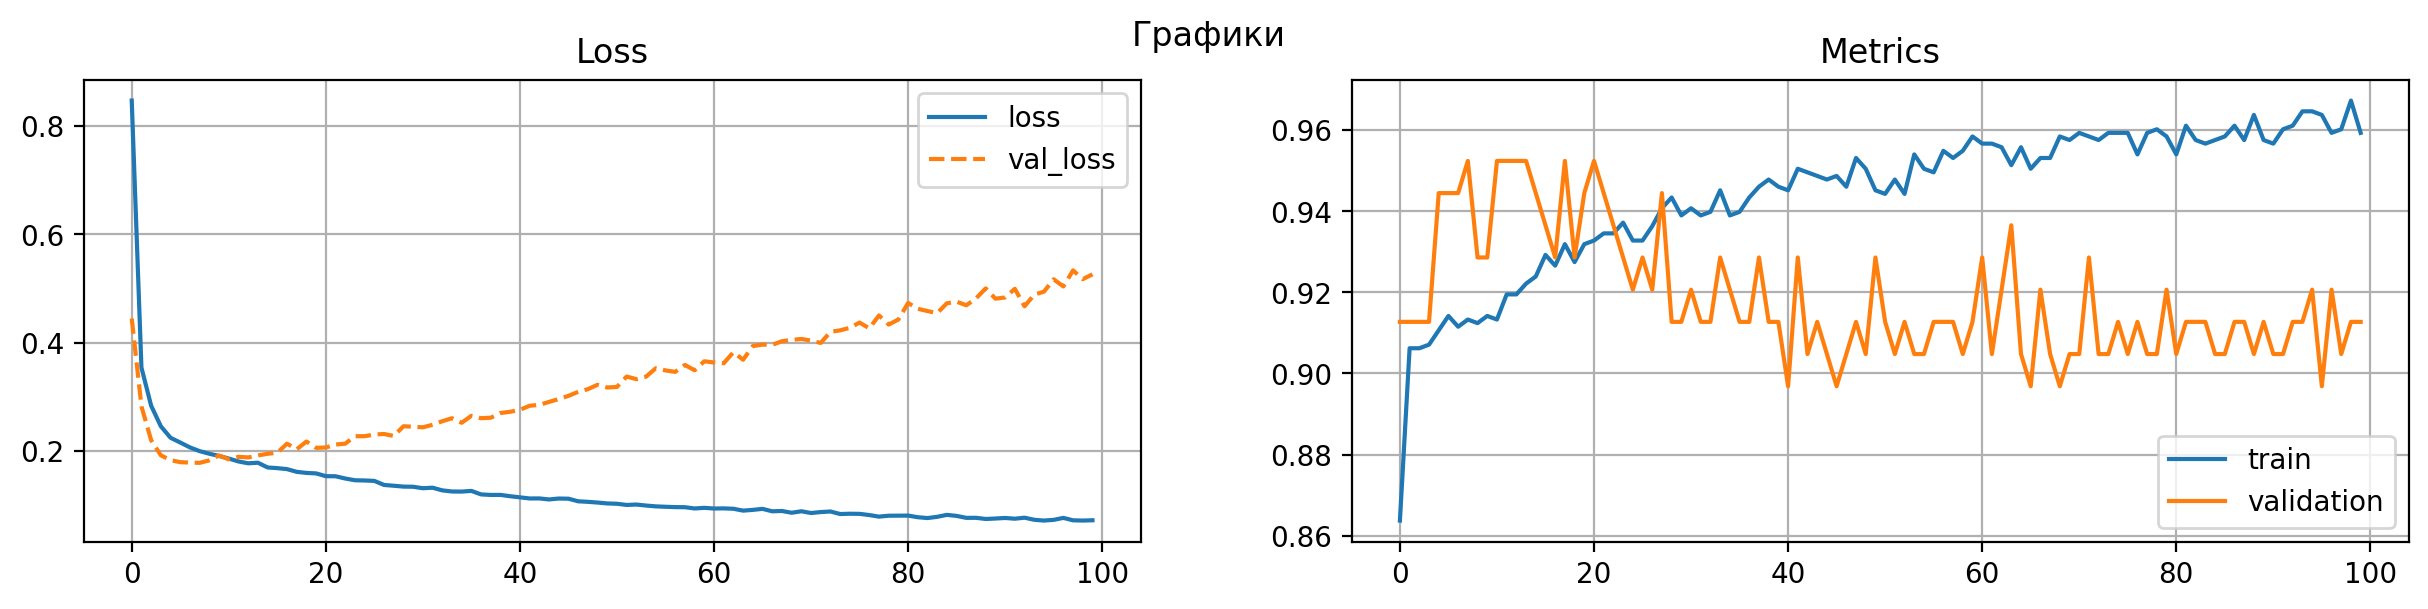

In [ ]:
#@title Визуализация процесса обучения

f,axes = plt.subplots(1, 2, figsize=(15,3), dpi=200)

f.suptitle('Графики')

axes[0].plot(history.history['loss'], '-', history.history['val_loss'],'--')
axes[0].legend(['loss','val_loss'])
axes[0].set_title('Loss')
axes[0].grid()

axes[1].plot(history.history['accuracy'], '-' , history.history['val_accuracy'])
axes[1].legend(['train','validation'])
axes[1].set_title('Metrics')
axes[1].grid()

plt.show()

In [ ]:
#@title sklearn_classification_report (f1-score)

y_pred = model_1.predict(x_test_dataset, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test_dataset,axis=1)

print(classification_report(y_test, y_pred_bool, target_names=classes))

40/40 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.95      0.96      0.95       295
ограниченно годен       0.24      0.24      0.24        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.91       315
        macro avg       0.39      0.40      0.40       315
     weighted avg       0.90      0.91      0.90       315



### metrics=['f1_score']

In [ ]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[''])

In [ ]:
# history = model_1.fit(x_train_dataset, y_train_dataset, batch_size=32, epochs=30, validation_data=(x_test_dataset, y_test_dataset))

## (2) Dense (со слоями нормализации BatchNormalization())

In [ ]:
model_2 = Sequential()
model_2.add(Dense(16, activation = 'relu', input_shape=(13178,)))
model_2.add(BatchNormalization())
model_2.add(Dense(32, activation = 'relu'))
model_2.add(BatchNormalization())
model_2.add(Dense( 3, activation = 'softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                210864    
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 211,699
Trainable params: 211,603
Non-tr

In [ ]:
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model_2.fit(x_train_dataset, y_train_dataset, batch_size=16, epochs=100, validation_split=0.1)

Epoch 1/100
71/71 [==============================] - 2s 10ms/step - loss: 0.9918 - accuracy: 0.5965 - val_loss: 0.7315 - val_accuracy: 0.9127
Epoch 2/100
71/71 [==============================] - 0s 6ms/step - loss: 0.5895 - accuracy: 0.8558 - val_loss: 0.5001 - val_accuracy: 0.9127
Epoch 3/100
71/71 [==============================] - 0s 7ms/step - loss: 0.3897 - accuracy: 0.9018 - val_loss: 0.3773 - val_accuracy: 0.9127
Epoch 4/100
71/71 [==============================] - 0s 6ms/step - loss: 0.2782 - accuracy: 0.9159 - val_loss: 0.3353 - val_accuracy: 0.9127
Epoch 5/100
71/71 [==============================] - 0s 7ms/step - loss: 0.2361 - accuracy: 0.9186 - val_loss: 0.2981 - val_accuracy: 0.9127
Epoch 6/100
71/71 [==============================] - 0s 7ms/step - loss: 0.2109 - accuracy: 0.9265 - val_loss: 0.2809 - val_accuracy: 0.9127
Epoch 7/100
71/71 [==============================] - 1s 8ms/step - loss: 0.1952 - accuracy: 0.9319 - val_loss: 0.2448 - val_accuracy: 0.9127
Epoch 8/100


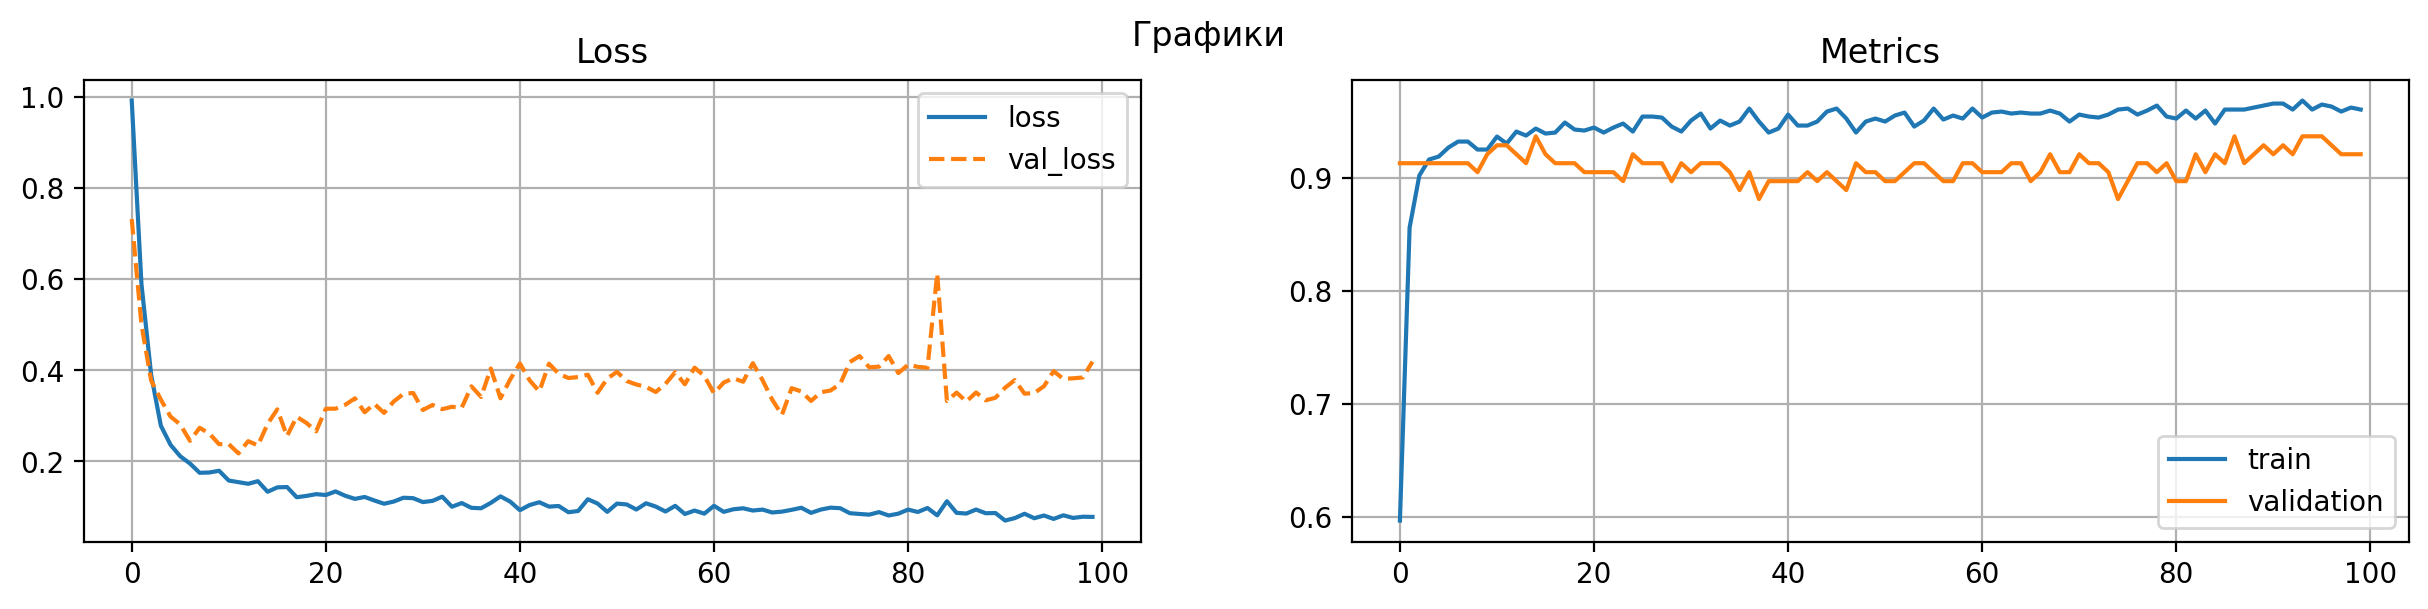

In [ ]:
#@title Визуализация процесса обучения

f,axes = plt.subplots(1, 2, figsize=(15,3), dpi=200)

f.suptitle('Графики')

axes[0].plot(history.history['loss'], '-', history.history['val_loss'],'--')
axes[0].legend(['loss','val_loss'])
axes[0].set_title('Loss')
axes[0].grid()

axes[1].plot(history.history['accuracy'], '-' , history.history['val_accuracy'])
axes[1].legend(['train','validation'])
axes[1].set_title('Metrics')
axes[1].grid()

plt.show()

In [ ]:
#@title sklearn_classification_report (f1-score)

y_pred = model_2.predict(x_test_dataset, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test_dataset,axis=1)

print(classification_report(y_test, y_pred_bool, target_names=classes))

40/40 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.94      0.92      0.93       295
ограниченно годен       0.12      0.18      0.14        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.87       315
        macro avg       0.35      0.37      0.36       315
     weighted avg       0.89      0.87      0.88       315



## (3)Dense (со слоями нормализации Dropout() + BatchNormalization())

In [ ]:
model_3 = Sequential()
model_3.add(Dense(16, activation = 'relu', input_shape=(13178,)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense(32, activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense( 3, activation = 'softmax'))

# model_3.summary()

In [ ]:
model_3.compile(optimizer= Adam(learning_rate = 0.00001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model_3.fit(x_train_dataset, y_train_dataset, batch_size=16, epochs=600, validation_split=0.1)

Epoch 1/600
71/71 [==============================] - 2s 10ms/step - loss: 1.7518 - accuracy: 0.3487 - val_loss: 1.1798 - val_accuracy: 0.0873
Epoch 2/600
71/71 [==============================] - 0s 7ms/step - loss: 1.7607 - accuracy: 0.3345 - val_loss: 1.2938 - val_accuracy: 0.0873
Epoch 3/600
71/71 [==============================] - 0s 6ms/step - loss: 1.6868 - accuracy: 0.3593 - val_loss: 1.4027 - val_accuracy: 0.0873
Epoch 4/600
71/71 [==============================] - 0s 7ms/step - loss: 1.7208 - accuracy: 0.3549 - val_loss: 1.4982 - val_accuracy: 0.0873
Epoch 5/600
71/71 [==============================] - 0s 7ms/step - loss: 1.5780 - accuracy: 0.3743 - val_loss: 1.5655 - val_accuracy: 0.0873
Epoch 6/600
71/71 [==============================] - 1s 11ms/step - loss: 1.6467 - accuracy: 0.3699 - val_loss: 1.5458 - val_accuracy: 0.0952
Epoch 7/600
71/71 [==============================] - 1s 11ms/step - loss: 1.6139 - accuracy: 0.3779 - val_loss: 1.5298 - val_accuracy: 0.1190
Epoch 8/60

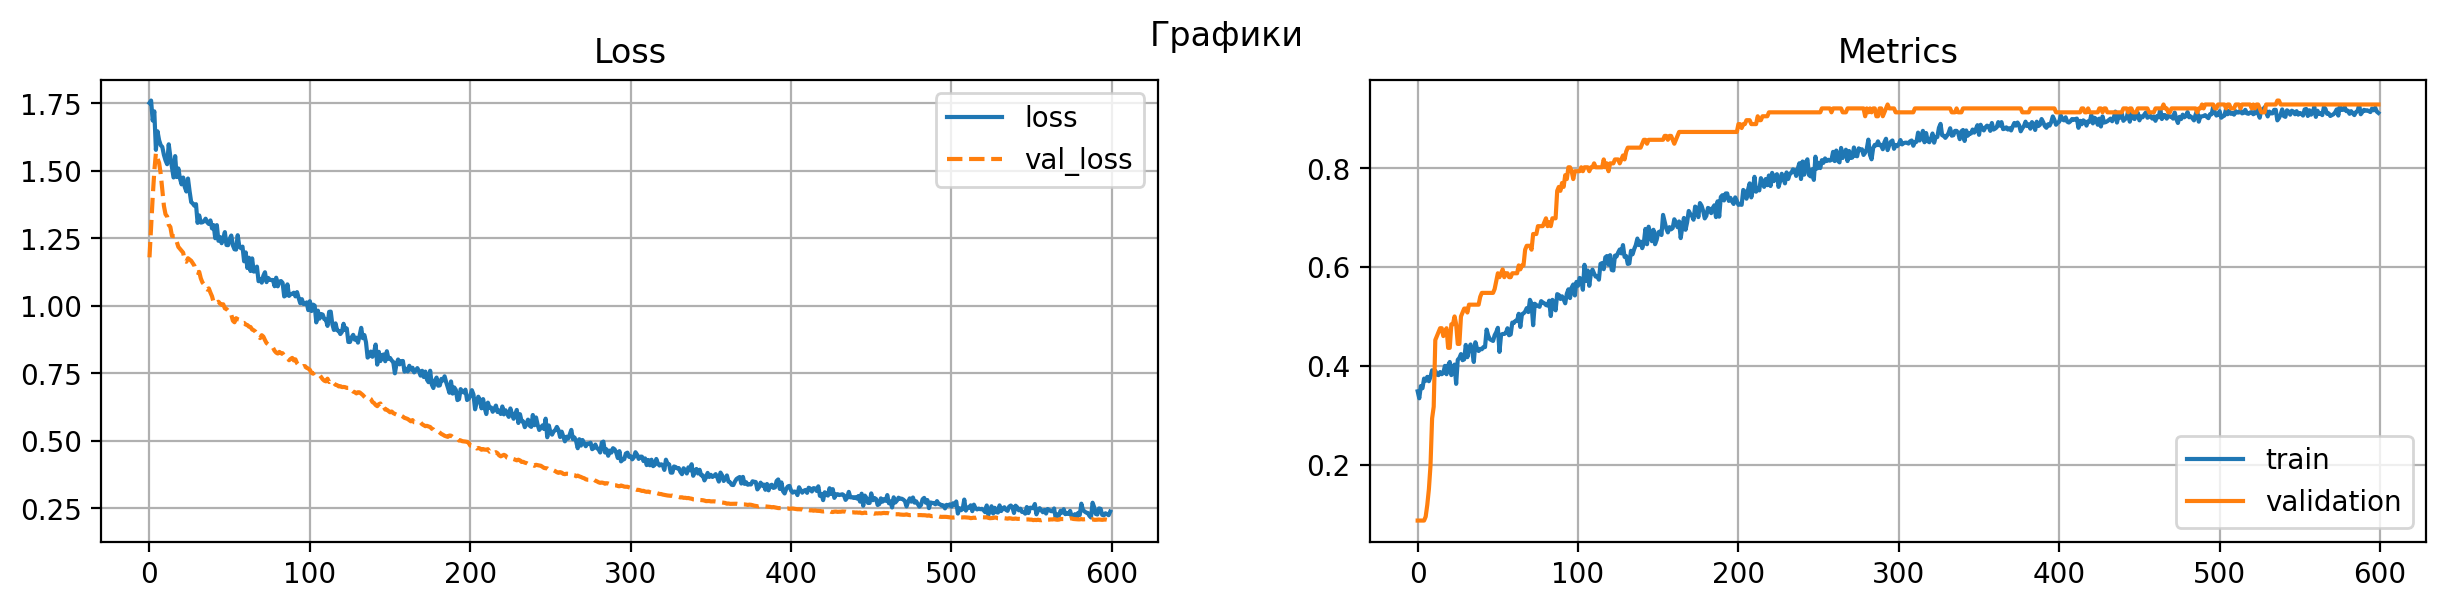

In [ ]:
#@title Визуализация процесса обучения

f,axes = plt.subplots(1, 2, figsize=(15,3), dpi=200)

f.suptitle('Графики')

axes[0].plot(history.history['loss'], '-', history.history['val_loss'],'--')
axes[0].legend(['loss','val_loss'])
axes[0].set_title('Loss')
axes[0].grid()

axes[1].plot(history.history['accuracy'], '-' , history.history['val_accuracy'])
axes[1].legend(['train','validation'])
axes[1].set_title('Metrics')
axes[1].grid()

plt.show()

In [ ]:
#@title sklearn_classification_report (f1-score)

y_pred = model_3.predict(x_test_dataset, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test_dataset,axis=1)

print(classification_report(y_test, y_pred_bool, target_names=classes))

40/40 [==============================] - 0s 3ms/step
                   precision    recall  f1-score   support

            годен       0.94      0.99      0.96       295
ограниченно годен       0.25      0.06      0.10        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.93       315
        macro avg       0.40      0.35      0.35       315
     weighted avg       0.89      0.93      0.91       315



## (4)

In [ ]:
model_4 = Sequential()
model_4.add(Dense(16, activation = 'relu', input_shape=(13178,)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense(32, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense(64, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense( 3, activation = 'softmax'))

# model_3.summary()

In [ ]:
model_4.compile(optimizer= Adam(learning_rate = 0.00001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model_4.fit(x_train_dataset, y_train_dataset, batch_size=16, epochs=600, validation_split=0.1)

Epoch 1/600
71/71 [==============================] - 3s 12ms/step - loss: 1.7323 - accuracy: 0.3186 - val_loss: 1.2981 - val_accuracy: 0.0556
Epoch 2/600
71/71 [==============================] - 1s 8ms/step - loss: 1.6468 - accuracy: 0.3407 - val_loss: 1.4030 - val_accuracy: 0.0317
Epoch 3/600
71/71 [==============================] - 1s 8ms/step - loss: 1.6439 - accuracy: 0.3513 - val_loss: 1.4332 - val_accuracy: 0.0238
Epoch 4/600
71/71 [==============================] - 1s 8ms/step - loss: 1.6468 - accuracy: 0.3265 - val_loss: 1.4553 - val_accuracy: 0.0238
Epoch 5/600
71/71 [==============================] - 1s 7ms/step - loss: 1.6084 - accuracy: 0.3389 - val_loss: 1.4529 - val_accuracy: 0.0317
Epoch 6/600
71/71 [==============================] - 1s 8ms/step - loss: 1.6722 - accuracy: 0.3283 - val_loss: 1.4802 - val_accuracy: 0.0476
Epoch 7/600
71/71 [==============================] - 1s 8ms/step - loss: 1.6222 - accuracy: 0.3283 - val_loss: 1.5085 - val_accuracy: 0.0556
Epoch 8/600


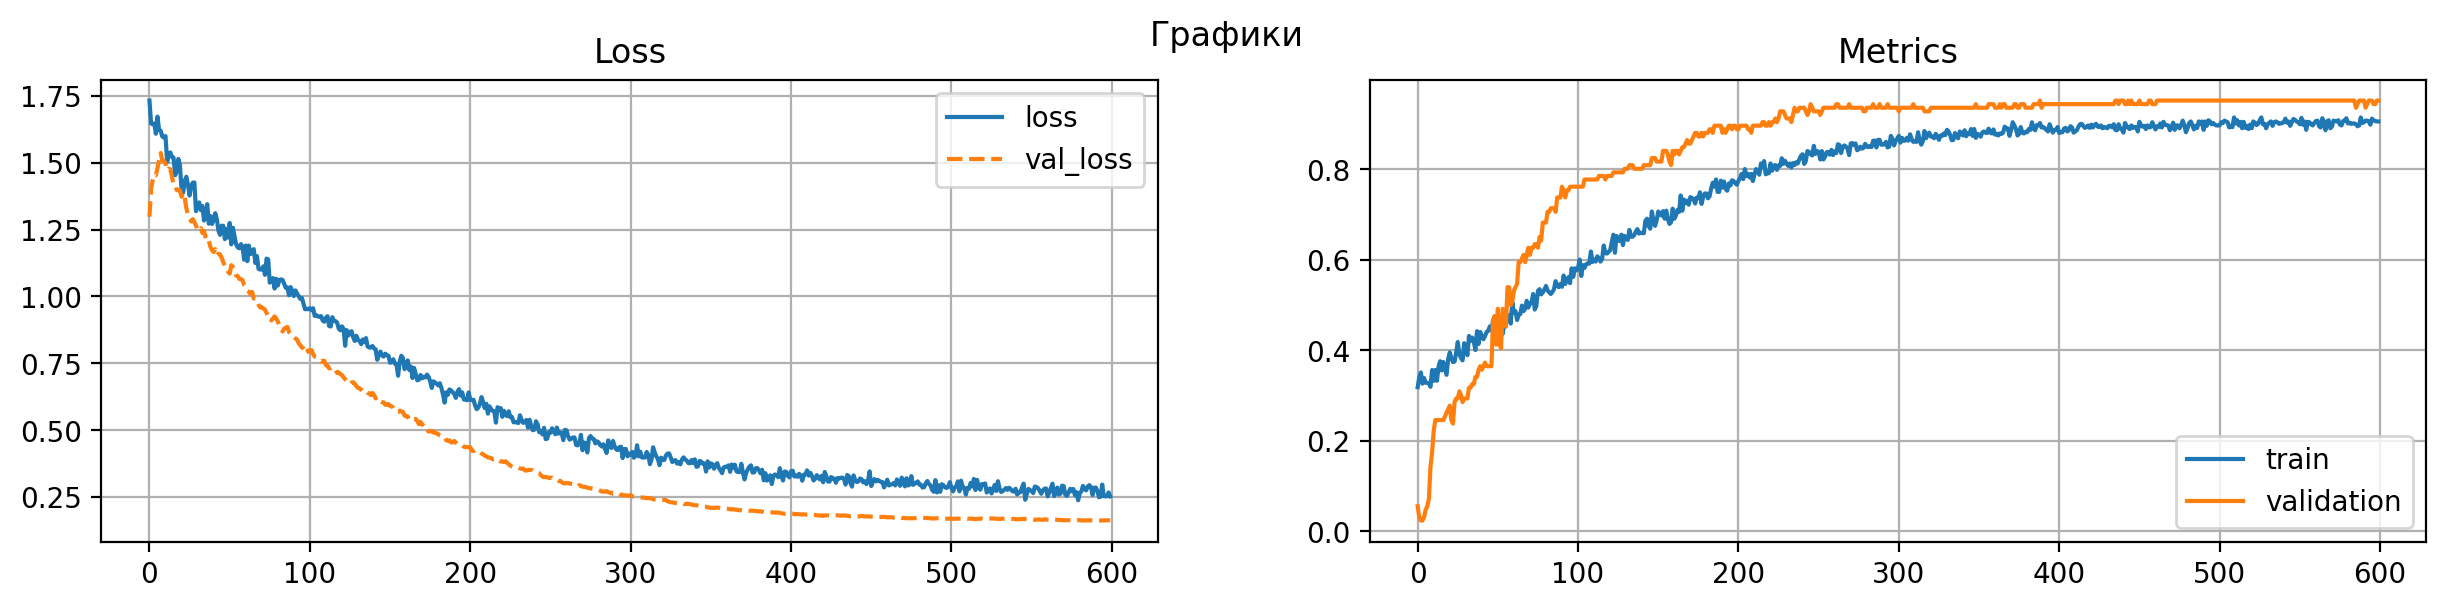

In [ ]:
#@title Визуализация процесса обучения

f,axes = plt.subplots(1, 2, figsize=(15,3), dpi=200)

f.suptitle('Графики')

axes[0].plot(history.history['loss'], '-', history.history['val_loss'],'--')
axes[0].legend(['loss','val_loss'])
axes[0].set_title('Loss')
axes[0].grid()

axes[1].plot(history.history['accuracy'], '-' , history.history['val_accuracy'])
axes[1].legend(['train','validation'])
axes[1].set_title('Metrics')
axes[1].grid()

plt.show()

In [ ]:
#@title sklearn_classification_report (f1-score)

y_pred = model_4.predict(x_test_dataset, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test_dataset,axis=1)

print(classification_report(y_test, y_pred_bool, target_names=classes))

40/40 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.94      0.98      0.96       295
ограниченно годен       0.12      0.06      0.08        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.92       315
        macro avg       0.35      0.35      0.35       315
     weighted avg       0.89      0.92      0.90       315



# AutoML (AutoKeras)

## Подготовка датасета

In [ ]:
df.head()

,КлиентПолПредставление,Возраст,ДиспансернаяГруппаПредставление,Профессия,ВредныеФакторы,ЗаключениеМК,ЛабораторныеИсследования1_ОАК_ЗначениеПредставление,ЛабораторныеИсследования1_Биохимия_ЗначениеПредставление,ЛабораторныеИсследования1_ОАМ_ЗначениеПредставление,ЛабораторныеИсследования1_МазокИзЗеваИНоса_ЗначениеПредставление,...,Психиатрия3_МКБ101,Психиатрия3_МКБ102,Психиатрия4_МКБ101,Психиатрия4_МКБ102,Оториноларингология3_МКБ101,mkb_all,mkb_all_unique,x_raw,x_clean,y_train
0,Женский,45,I,Ведущий специалист по организации обуения,11.4,Годен,получен,получен,получен,не получен,...,NaN,NaN,NaN,NaN,NaN,"Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,nan,nan,na...",[Z00.0],"Женский,I,11.4,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,Z...","[Женский, I, 11.4, Z00.0]","[1.0, 0.0, 0.0]"
1,Мужской,34,IIIа,Ведущий специалист,4.2.5,Годен,получен,получен,получен,не получен,...,NaN,NaN,NaN,NaN,NaN,"Z00.0,Z00.0,nan,nan,nan,nan,Z00.0,Z00.0,Z00.0,...","[I11.9, Z00.0]","Мужской,IIIа,4.2.5,Z00.0,Z00.0,nan,nan,nan,nan...","[Мужской, IIIа, 4.2.5, Z00.0, I11.9]","[1.0, 0.0, 0.0]"
2,Мужской,36,II,Главный менеджер,4.2.5,ГоденСКоррекциейЗрения,получен,получен,получен,не получен,...,NaN,NaN,NaN,NaN,NaN,"Z00.0,H52.1,nan,nan,nan,nan,Z00.0,nan,nan,Z00....","[Z00.0, H52.1]","Мужской,II,4.2.5,Z00.0,H52.1,nan,nan,nan,nan,Z...","[Мужской, II, 4.2.5, Z00.0, H52.1]","[0.0, 1.0, 0.0]"
3,Мужской,33,I,Главный специалист,11.1,Годен,получен,получен,получен,получен,...,NaN,NaN,NaN,NaN,NaN,"nan,Z00.0,Z00.0,Z00.0,nan,Z00.0,nan,nan,Z00.0,...",[Z00.0],"Мужской,I,11.1,nan,Z00.0,Z00.0,Z00.0,nan,Z00.0...","[Мужской, I, 11.1, Z00.0]","[1.0, 0.0, 0.0]"
4,Мужской,37,II,Старший специалист,11.1,ГоденСКоррекциейЗрения,получен,получен,получен,не получен,...,NaN,NaN,NaN,NaN,NaN,"nan,H52.2,Z00.0,nan,nan,Z00.0,nan,nan,Z00.0,Z0...","[Z00.0, H52.2]","Мужской,II,11.1,nan,H52.2,Z00.0,nan,nan,Z00.0,...","[Мужской, II, 11.1, H52.2, Z00.0]","[0.0, 1.0, 0.0]"


In [ ]:
# df.columns

Index(['КлиентПолПредставление', 'Возраст', 'ДиспансернаяГруппаПредставление',
       'Профессия', 'ВредныеФакторы', 'ЗаключениеМК',
       'ЛабораторныеИсследования1_ОАК_ЗначениеПредставление',
       'ЛабораторныеИсследования1_Биохимия_ЗначениеПредставление',
       'ЛабораторныеИсследования1_ОАМ_ЗначениеПредставление',
       'ЛабораторныеИсследования1_МазокИзЗеваИНоса_ЗначениеПредставление',
       ...
       'Психиатрия3_МКБ101', 'Психиатрия3_МКБ102', 'Психиатрия4_МКБ101',
       'Психиатрия4_МКБ102', 'Оториноларингология3_МКБ101', 'mkb_all',
       'mkb_all_unique', 'x_raw', 'x_clean', 'y_train'],
      dtype='object', length=1631)

In [ ]:
# val_dataframe = dataframe.sample(frac=0.2, random_state=1338)
# train_dataframe = dataframe.drop(val_dataframe.index)

In [ ]:
# def dataframe_to_dataset(dataframe):
#     dataframe = dataframe.copy()
#     labels = dataframe.pop("target")
#     ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
#     ds = ds.shuffle(buffer_size=len(dataframe))
#     return ds


# train_ds = dataframe_to_dataset(train_dataframe)
# val_ds = dataframe_to_dataset(val_dataframe)

# Расширение данных на основе нормативной документации

In [ ]:
# df_extension = pd.read_excel('/content/drive/MyDrive/NU_files/стажировка/spr_mkb10.xls')

In [ ]:
# df_extension.head()

In [ ]:
# df_extension = df_extension.drop('class_id', axis=1)
# df_extension.head()

In [ ]:
# list_1 = df_extension['mkb_cod']

In [ ]:
# def extension(arg):
#     mkb = df_extension['mkb_cod']
#     if mkb in list_1:
#         df_extension['factors_diseased']

In [ ]:
# vocabulary_mkb[:5]

In [ ]:
# print(vocabulary_mkb.index('A00'))
# print(vocabulary_mkb.index('A09'))

In [ ]:
# list_1 = vocabulary_mkb[0:68]
# list_1

In [ ]:
# import random

# random.choice(list_1)

In [ ]:
# vocabulary_mkb.index('E84')

In [ ]:
# vocabulary_mkb[vocabulary_mkb.index('E84'):2420]
# print(vocabulary_mkb.index('A09'))